# Applying PCA to Interpolated Data
---

I followed the Python Data Science Handbook [In Depth: Principal Component Analysis](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html) notebook to apply PCA to the interpolated shallow profiler data.

The motivation for this is that time-series data from the oceans can have high dimensionality and strong multicollinearity, and PCA can extract features that (hopefully) maintain the signals we're interested in while providing us with a lower-dimension dataframe to use in modeling. This allows analysis to be scaled up to include several years of measurements for several variables and locations without requiring truly excessive computational resources.

Keep in mind two assumptions of PCA: 
1. **Linearity:** PCA detects and controls for linear relationships, so we assume that the data does not hold nonlinear relationships (or that we don't care about these nonlinear relationships).
2. **Large variances define importance:** If data is spread in a direction, that direction is important! If there is little spread in a direction, that direction is not very important.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.decomposition import PCA

%matplotlib inline

### Read in the data

In [2]:
df = pd.read_csv('../../coastal_upwelling_output/interpolated.csv')
df.rename({'Unnamed: 0':'time'},inplace=True, axis=1)
df.set_index('time', inplace=True)
df.drop(columns=['CUTI', 'upwelling'], inplace=True)

In [3]:
df

,5.12,6.12,7.12,8.12,9.12,10.12,11.12,12.12,13.12,14.12,...,187.12,188.12,189.12,190.12,191.12,192.12,193.12,194.12,195.12,196.12
time,,,,,,,,,,,,,,,,,,,,,
2018-07-17 17:18:50.061576192,14.239120,14.197892,14.120385,14.183533,14.177953,14.100703,13.851424,13.837088,12.623838,11.932778,...,7.074763,7.058592,7.050526,7.043378,7.040205,7.035856,7.038597,7.016340,7.009253,7.012501
2018-07-17 18:58:50.061576192,14.226363,14.221012,14.210943,14.090408,14.032935,13.983300,12.801985,13.000087,11.998454,11.847009,...,7.279637,7.272901,7.240001,7.199019,7.156269,7.101412,7.100403,7.097658,7.095298,7.091719
2018-07-17 20:38:50.061576192,14.213606,14.170973,14.111121,14.363632,14.302021,14.101116,12.881438,12.688296,11.618997,11.278748,...,7.151859,7.143864,7.144203,7.134701,7.142472,7.130818,7.118297,7.111259,7.115614,7.136021
2018-07-17 22:18:50.061576192,14.194031,14.120934,14.011299,14.521989,14.460151,14.142456,12.963377,12.452501,12.758078,11.334977,...,7.257718,7.252802,7.252564,7.235814,7.215926,7.208012,7.204803,7.194276,7.194837,7.184467
2018-07-17 23:58:50.061576192,14.178797,14.047812,13.911478,14.367444,14.301861,13.985794,12.869543,12.399282,12.618458,11.285852,...,7.342397,7.333815,7.333184,7.303140,7.269075,7.262869,7.262194,7.246321,7.218759,7.202921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-25 18:18:50.061576192,12.009427,11.969547,11.948662,11.957151,11.951459,11.951264,11.950559,11.952439,11.952135,11.951317,...,8.743345,8.720970,8.717754,8.718795,8.702370,8.700583,8.692802,8.692991,8.676325,8.531894
2018-12-25 19:58:50.061576192,12.010936,11.974380,11.958668,11.960412,11.960536,11.959915,11.959270,11.960162,11.959669,11.959297,...,8.786390,8.748656,8.735592,8.721730,8.698430,8.706427,8.677161,8.673193,8.629320,8.534748
2018-12-25 21:38:50.061576192,12.009219,11.979283,11.968675,11.969587,11.969181,11.969323,11.968919,11.970177,11.968905,11.967400,...,8.741195,8.737502,8.726418,8.711138,8.692003,8.653904,8.643551,8.628373,8.617202,8.537602


The goal is to reduce these 192 columns to a significantly smaller number while retaining most of the original signals in the data.

In [4]:
df.shape[0] * df.shape[1]

446208

Imagine how many more values this dataframe would have if we added a few more years of observations, increased the depth resolution, or appended more variables, like salinity or dissolved oxygen. Applying PCA will significantly reduce the number of calculations required in modeling.

### Choosing the number of components

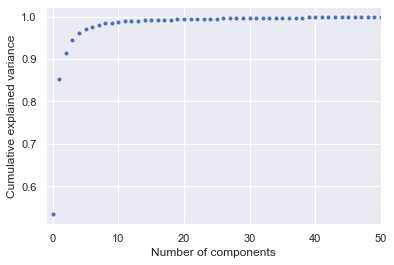

In [5]:
pca = PCA().fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_), '.')
plt.xlim(-1, 50)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

I'll include the first 4 components to explain roughly 95% of the variance.

### Applying PCA

In [6]:
pca = PCA(n_components=4).fit(df)

In [7]:
components = pca.transform(df)

In [8]:
filtered = pca.inverse_transform(components)

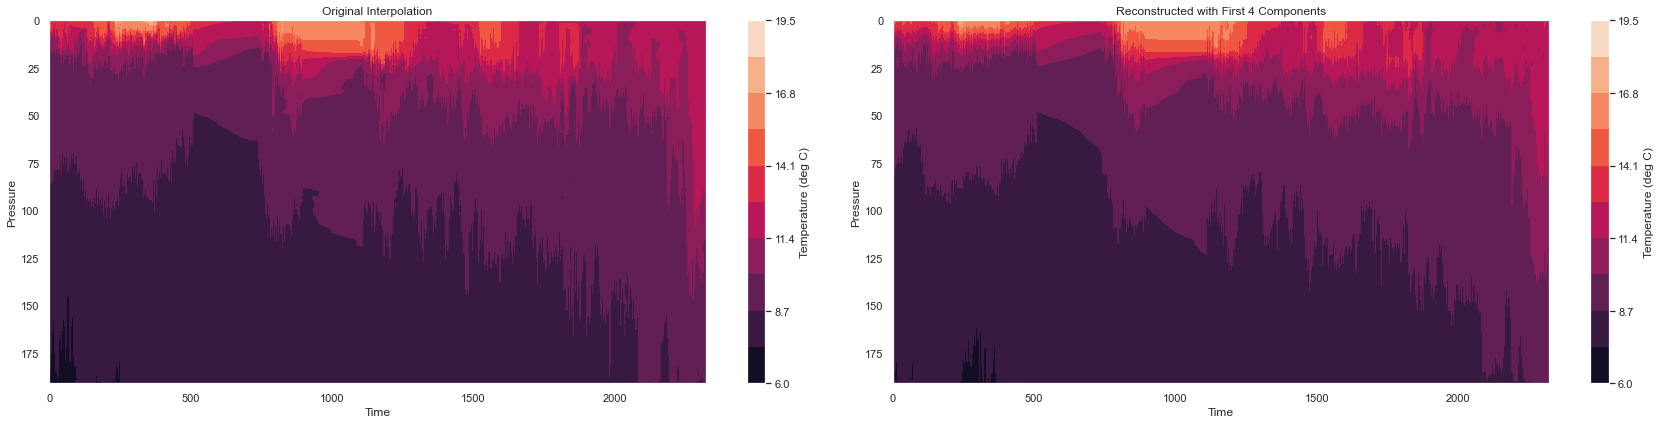

In [9]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(24,6))

# Make sure these plot on the same color scales
vmin = 6
vmax = 19.5
levels = np.linspace(vmin, vmax, 11)

cf1 = ax1.contourf(df.T, levels=levels)
ax1.set_ylabel('Pressure')
ax1.set_xlabel('Time')
ax1.set_title('Original Interpolation')
cb1 = plt.colorbar(cf1, ax=ax1)
cb1.set_label('Temperature (deg C)')
ax1.invert_yaxis()

cf2 = ax2.contourf(filtered.T, levels=levels)
ax2.set_ylabel('Pressure')
ax2.set_xlabel('Time')
ax2.set_title('Reconstructed with First 4 Components')
cb2 = plt.colorbar(cf2, ax=ax2)
cb2.set_label('Temperature (deg C)')
ax2.invert_yaxis()

plt.tight_layout()

We can see how well this process did at reconstructing the interpolated data using the first 4 components. Note that the axes ticks are indices, not actual pressure or time measurements. 